# 準備

git cloneで今回利用するファイルを取得

In [2]:
!git clone https://github.com/labdemy-lectureteam/RAG-lecture-lesson1.git

Cloning into 'RAG-lecture-lesson1'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 56 (delta 17), reused 50 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 888.12 KiB | 6.88 MiB/s, done.
Resolving deltas: 100% (17/17), done.


必要パッケージのインストール

In [3]:
%pip install -qU langchain_community
%pip install -qU pypdf
%pip install -qU nltk
%pip install -qU langchain_openai langchain_chroma
%pip install -qU unstructured
%pip install -qU datasets
%pip install -qU ragas
%pip install -qU tqdm
%pip install -qU japanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.8 MB/s eta 0:00:00
 

API KEYの設定

In [7]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# RAG関連の関数の定義

streamlitアプリのrag.pyのコードをほとんどそのままコピペしてきてます。

In [88]:
from langchain_community.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
import shutil
import os
from langchain_openai import ChatOpenAI
import chromadb

from typing import List, Dict, Any
from langchain_core.vectorstores import VectorStore
from langchain_core.documents import Document

def load_PDF(path: str) -> List[Document]:
    if os.path.isdir(path):
        loader = PyPDFDirectoryLoader(path, glob="*.pdf")
        try:
            documents = loader.load()
        except Exception as error:
            print(error)
    elif os.path.isfile(path):
        if not path.lower().endswith('.pdf'):
            raise ValueError(f"与えられたファイル：  '{path}' はPDFではありません.")
        loader = PyPDFLoader(path)
        documents = loader.load()
    else:
        raise ValueError(f"与えられたパス： '{path}' はファイルでもディレクトリでもありません。")
    if not documents:
        raise ValueError(f"与えられたパス： '{path}' からのファイルの読み込みに失敗しました。")
    return documents

def create_chunks(documents: List[Document], chunk_size: int, chunk_overlap: int) -> List[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        add_start_index=True
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

def init_vector_db(embedding_model:Any,db_path:str)->Chroma:
    if os.path.exists(db_path):
        shutil.rmtree(db_path)
    chromadb.api.client.SharedSystemClient.clear_system_cache()
    vector_db = Chroma(
        collection_name='rag_app_collection',
        embedding_function=embedding_model,
        persist_directory=db_path,
        collection_metadata={"hnsw:space": "cosine"}
        )
    return vector_db

def get_context_from_db(vector_db:VectorStore, query:str, k:int=5, score_threshold:float=None)->List[Document]:
    contexts = vector_db.similarity_search_with_relevance_scores(query,
                                                                 k=k,
                                                                 score_threshold=score_threshold)
    return contexts

def format_prompt(contexts:List[Document], query:str, chat_history:List[Dict[str, str]])->str:
    PROMPT = """
    You are a helpful assistant. Answer the following questions based on the given context:
    chat history: {CHAT_HISTORY}

    context: {CONTEXT}

    Answer the following questions based on the given context:
    query: {QUERY}
    """
    prompt = ChatPromptTemplate.from_template(PROMPT)
    chat_history = '\n\n'.join([f"{message['role']}: {message['content']}" for message in chat_history])
    sources = [ {'source':doc[0].metadata['source'],'page':doc[0].metadata['page']} for doc in contexts ]
    contexts = '\n'.join([f"CONTEXT {idx}:\n{res.page_content}" for idx, (res, _score) in enumerate(contexts)])
    prompt = prompt.format(CHAT_HISTORY=chat_history,CONTEXT=contexts, QUERY=query)
    return prompt, sources

## ベクトル化

In [26]:
documents = load_PDF("/content/RAG-lecture-lesson1/sample_files")
chunks = create_chunks(documents=documents, chunk_size=100, chunk_overlap=0)
embedding_model= OpenAIEmbeddings(model='text-embedding-3-small')
vector_db = init_vector_db(embedding_model=embedding_model,db_path="database")
vector_db.add_documents(documents=chunks)

['1e42e498-67d8-4fc2-94da-6b917eadc77b',
 '6b853c5f-0249-43a5-8f0b-c9c2b9cf15b5',
 '7400ffc8-db8e-426b-be75-e6f10046603c',
 '00e923c1-0cc6-48ff-a276-4fabcac04e96',
 'adf1d866-98b4-4b38-995f-6a44901e54ab',
 '3de52ba0-6bbe-4ea0-9283-22f674ae984b',
 '3d7ae24c-16ef-4840-b910-b6a25cb0b36f',
 '5cbf75b7-721d-428d-9f57-561729422774',
 '234bfc94-0fd8-4301-a129-b4de3c0522ef',
 '625630db-44c7-4bfd-a1ba-6e4ca0c282af',
 '6aade377-f6d8-4074-8581-9e834a4bcb72',
 '4167b307-34d3-4b70-b2ee-ff8b866fa49d',
 '7461ebfb-6670-4483-a881-2972a4700315',
 '087e134f-fbb5-499b-833e-4c63253c623b',
 'cc755723-b3e4-472e-8435-49be24072792',
 '7e992826-5a58-4041-a543-e545806711a4',
 '7a740968-ba25-44ef-863e-3038c73e44f9',
 'd616d2b1-3c04-43cb-8ecd-0e6463240b70']

# RAGAsによるRAGの評価

## 質問とそれに対応する理想的な回答の用意

In [27]:
# 質問集
questions = ["この講義はどういうものですか？",
             "主催者はどういう団体ですか？",
             "合計何回の講義がありますか？",
             "講義日程はどうなってますか？",
             "参加したい場合はどうすれば良いですか？",
             "担当者の連絡先を教えてください",
             "参加費はいくらですか？",
             "何か事前準備は必要ですか？"]

# 理想的な回答
ideal_answers = ["この講義はRAGについて学ぶ講義です。",
                 "主催者はAI人材の育成に取り組んでいるLabdemyという団体です。",
                 "講義は合計4回です。",
                 "講義日程は：\n 第1回 2/2 (日) 14:00~15:30 \n 第2回 2/9 (日) 14:00~15:30 \n 第3回 2/16 (日) 14:00~15:30 \n 第4回 2/23 (日) 14:00~15:30 \nです。",
                 "参加したい場合はこちらの[リンク](https://discord.gg/JaQPZ5Gx?event=1323252933327847464)からdiscordサーバーに参加してください。",
                 "担当者の連絡先はlecture@labdemy.comです。",
                 "参加費は無料です。",
                 "事前準備はPython環境の準備、基礎的なプログラミング知識が必要です。"]

## 回答の生成

In [28]:
from langchain.chat_models import ChatOpenAI
from tqdm import tqdm

# モデルの準備
chat_model = ChatOpenAI(model_name="gpt-4", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

# チャット履歴
chat_history = [] #これはずっと空っぽのまま

# コンテキスト情報
contexts = []

# LLMの回答
model_answers = []

# 各質問に対して回答を生成し、それを記録していく
for question in tqdm(questions):
  context = get_context_from_db(vector_db,question)
  # contextから、文章のみを抽出して記録する
  context_text = [item[0].page_content for item in context]
  contexts.append(context_text)

  final_prompt,_ = format_prompt(context, question,chat_history)
  response = chat_model.invoke(final_prompt)
  # モデルの回答を記録
  model_answers.append(response.content)

<ipython-input-28-6274483e4634>:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat_model = ChatOpenAI(model_name="gpt-4", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
 12%|█▎        | 1/8 [00:04<00:32,  4.63s/it]<ipython-input-25-bd2c6b96f717>:55: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='6aade377-f6d8-4074-8581-9e834a4bcb72', metadata={'creationdate': '2024-12-30T12:27:58+00:00', 'creator': 'Chromium', 'moddate': '2024-12-30T12:27:58+00:00', 'page': 1, 'page_label': '2', 'producer': 'Skia/PDF m119', 'source': '/content/RAG-lecture-lesson1/sample_files/RAG講義のテスト受講案内.pdf', 'start_index': 451, 'total_pages': 3}, page_content='必要な準備： Python 環

## RAGAs評価

In [29]:
#評価データセット作成
from datasets import Dataset

eval_dataset_dict = {
  "user_input": questions, #質問集
  "response": model_answers, #LLMの回答
  "retrieved_contexts": contexts, #コンテキスト情報
  "reference": ideal_answers #理想的な回答
}

eval_dataset = Dataset.from_dict(eval_dataset_dict)

In [30]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

In [31]:
scores = evaluate(
    dataset=eval_dataset,
    metrics=[context_precision,context_recall,answer_relevancy,faithfulness]
)

print(scores)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

{'context_precision': 0.6667, 'context_recall': 0.8125, 'answer_relevancy': 0.8276, 'faithfulness': 0.8438}


**評価値の解釈(復習)：**

retreivalに対する評価
- context precision: 検索して取り出した情報のうち、本当に役に立った情報の割合
- context recall: 必要な情報をどれくらい取りこぼさずに取得できたか

回答に対する評価
- answer relevancy: 質問に対してどれくらい良い回答になってるか
- faithfulness: 「hallucination」を測る指標



In [49]:
# 各質問に対する評価値を個別で見ることも可能
scores['context_precision']

[0.499999999975,
 0.0,
 0.8333333332916666,
 0.9999999999,
 0.49999999995,
 0.49999999995,
 0.9999999999,
 0.9999999999]

In [71]:
for question,model_answer,context,ideal_answer,cp,cr,ar,ft in zip(questions,model_answers,contexts,ideal_answers,scores['context_precision'],scores['context_recall'],scores['answer_relevancy'],scores['faithfulness']):
  print("="*20)
  print("\n【元々の質問】\n",question,"\n")
  print("【理想的な回答】\n",ideal_answer,"\n")
  print("【context情報】")
  for c in context:
    print('-',c)
  print("\n")
  print("【LLMの回答】\n",model_answer,"\n")
  print(f"【評価】\n cp:{cp:.2f}, cr:{cr:.2f}, ar:{ar:.2f}, ft:{ft:.2f} \n")


【元々の質問】
 この講義はどういうものですか？ 

【理想的な回答】
 この講義はRAGについて学ぶ講義です。 

【context情報】
- 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に
- 務課題の経験を通して真に AI を活⽤できる⼈材の育成に取り組んでいます。
講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付
- 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
- この度は、 Labdemy の RAG （ Retrieval-Augmented Generation ）講義のテスト受講に
ご興味を⽰していただき、誠にありがとうございます！
- RA G 講 義 の テ ス ト 受 講 案 内
1
R A G 講義のテスト受講案内


【LLMの回答】
 Assistant: 
この講義は、RAG（Retrieval-Augmented Generation）について網羅的に学ぶものです。合計4回の講義を通じて、AIを活用できる人材の育成に取り組んでいます。講義は全てオンラインで行われ、Zoomリンクを通じて参加することができます。 

【評価】
 cp:0.50, cr:1.00, ar:0.77, ft:0.75 


【元々の質問】
 主催者はどういう団体ですか？ 

【理想的な回答】
 主催者はAI人材の育成に取り組んでいるLabdemyという団体です。 

【context情報】
- 必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
- 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
- RA G 講 義 の テ ス ト 受 講 案 内
3
講義期間中のサポート体制について
- この

## chunk sizeの最適化

In [10]:
from datasets import Dataset

# 質問集
questions = ["この講義はどういうものですか？",
             "主催者はどういう団体ですか？",
             "合計何回の講義がありますか？",
             "講義日程はどうなってますか？",
             "参加したい場合はどうすれば良いですか？",
             "担当者の連絡先を教えてください",
             "参加費はいくらですか？",
             "何か事前準備は必要ですか？"]

# 理想的な回答
ideal_answers = ["この講義はRAGについて学ぶ講義です。",
                 "主催者はAI人材の育成に取り組んでいるLabdemyという団体です。",
                 "講義は合計4回です。",
                 "講義日程は：\n 第1回 2/2 (日) 14:00~15:30 \n 第2回 2/9 (日) 14:00~15:30 \n 第3回 2/16 (日) 14:00~15:30 \n 第4回 2/23 (日) 14:00~15:30 \nです。",
                 "参加したい場合はこちらの[リンク](https://discord.gg/JaQPZ5Gx?event=1323252933327847464)からdiscordサーバーに参加してください。",
                 "担当者の連絡先はlecture@labdemy.comです。",
                 "参加費は無料です。",
                 "事前準備はPython環境の準備、基礎的なプログラミング知識が必要です。"]

In [ ]:
chunk_sizes = [50, 100, 200, 300, 400, 500]
chunk_scores = []
eval_dataset_dicts = []

for chunk_size in tqdm(chunk_sizes):

  # chunk分けとベクトルDBへの保存
  documents = load_PDF("/content/RAG-lecture-lesson1/sample_files")
  chunks = create_chunks(documents=documents, chunk_size=chunk_size, chunk_overlap=0)
  embedding_model= OpenAIEmbeddings(model='text-embedding-3-small')
  vector_db = init_vector_db(embedding_model=embedding_model,db_path="database")
  vector_db.add_documents(documents=chunks)

  # 回答の生成
  chat_model = ChatOpenAI(model_name="gpt-4", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
  chat_history,contexts, model_answers = [], [], []
  for question in questions:
    context = get_context_from_db(vector_db,question)
    context_text = [item[0].page_content for item in context]
    contexts.append(context_text)
    final_prompt,_ = format_prompt(context, question,chat_history)
    response = chat_model.invoke(final_prompt)
    model_answers.append(response.content)

  # 評価用データセットの作成
  eval_dataset_dict = {
    "user_input": questions, #質問集
    "response": model_answers, #LLMの回答
    "retrieved_contexts": contexts, #コンテキスト情報
    "reference": ideal_answers #理想的な回答
  }
  eval_dataset_dicts.append(eval_dataset_dict)

  eval_dataset = Dataset.from_dict(eval_dataset_dict)

  # 評価
  scores = evaluate(
    dataset=eval_dataset,
    metrics=[context_precision,context_recall,answer_relevancy,faithfulness]
  )

  chunk_scores.append(scores)


  0%|          | 0/6 [00:00<?, ?it/s]

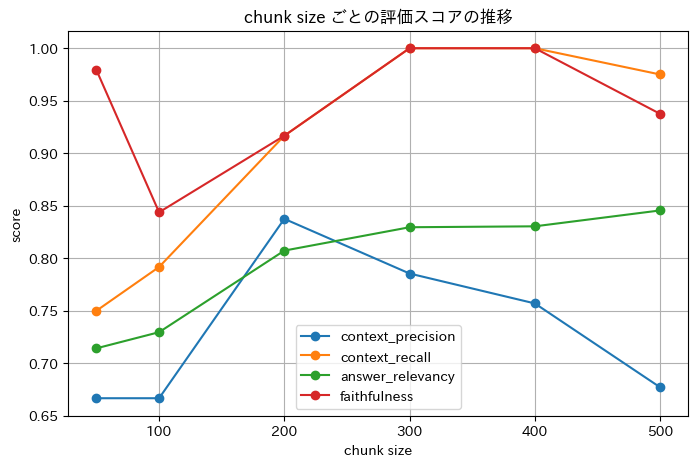

In [37]:
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

metrics = ['context_precision','context_recall','answer_relevancy','faithfulness']

# x軸の定義
x_values = chunk_sizes

# 描写の準備
plt.figure(figsize=(8, 5))

# 各評価指標を別々の線として描写
for metric in metrics:
    y_values = [sum(item[metric])/len(item[metric]) for item in chunk_scores]  # 各評価指標の値を取得
    plt.plot(x_values, y_values, marker='o', label=metric)  # 線を描写

# ラベル等の設定
plt.xlabel("chunk size")
plt.ylabel("score")
plt.title("chunk size ごとの評価スコアの推移")
plt.legend()
plt.grid(True)

plt.show()

In [77]:
chunk_scores[3]['context_precision'][3]

0.499999999975

In [78]:
# chunk size 300 の時の 4番目の質問について見てみる
print("="*20)
print("\n【元々の質問】\n",eval_dataset_dicts[3]['user_input'][3],"\n")
print("【理想的な回答】\n",eval_dataset_dicts[3]['reference'][3],"\n")
print("【context情報】")
for c in eval_dataset_dicts[3]['retrieved_contexts'][3]:
  print('-',c)
print("\n")
print("【LLMの回答】\n",eval_dataset_dicts[3]['response'][3],"\n")

print(f"【評価】\n cp:{chunk_scores[3]['context_precision'][3]:.2f}, cr:{chunk_scores[3]['context_recall'][3]:.2f}, ar:{chunk_scores[3]['answer_relevancy'][3]:.2f}, ft:{chunk_scores[3]['faithfulness'][3]:.2f} \n")


【元々の質問】
 講義日程はどうなってますか？ 

【理想的な回答】
 講義日程は：
 第1回 2/2 (日) 14:00~15:30 
 第2回 2/9 (日) 14:00~15:30 
 第3回 2/16 (日) 14:00~15:30 
 第4回 2/23 (日) 14:00~15:30 
です。 

【context情報】
- RA G 講 義 の テ ス ト 受 講 案 内
1
R A G 講義のテスト受講案内
この度は、 Labdemy の RAG （ Retrieval-Augmented Generation ）講義のテスト受講に
ご興味を⽰していただき、誠にありがとうございます！
L a b d e m y について
Labdemy では、最先端の AI を研究レベルでマスターすることを⽬的に、深い学びと実
務課題の経験を通して真に AI を活⽤できる⼈材の育成に取り組んでいます。
講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付
- 第 1 回  2/2  ⽇  14001530
第 2 回  2/9  ⽇  14001530
第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
Join the Labdemy School Beta Discord Server!
- RA G 講 義 の テ ス ト 受 講 案 内
3
講義期間中のサポート体制について
講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に
メンションを付けて質問をしてください。可能な限り迅速に回答いたしますが、質問内
容に応じて返信に時間がかかる場合がございます。
お問い合わせ先
もしご質問等ございましたら、  lecture@labdemy.com 宛にご連絡ください。
- RA G 講 義 の テ ス

## 理想的な回答の自動生成